<h1><center>Car Features and MSRP</h1>

One of the most significant purchases in many people's lives is a car. Not only is it one of the most expensive purchases (after a house), it is one that is often used daily. Whether buying a car new or used, a saavy consumer will do some research to determine the best fit, from both a feature and value standpoint. Conversely, it is important for car manufacturers to understand what consumers value to determine a fair Manufacturer Suggested Retail Price (MSRP). This study will investigate the relationship between a car's features and its MSRP.

### Data Loading and Cleaning

In [39]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
import pandas as pd
import scipy
import numpy as np
import math
import datetime

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [93]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from regressors import stats,plots

from collections import Counter

The original data set used was scraped from www.thecarconnection.com and collected by nicolas-gervais in the r/datasets on Reddit avaiable here: https://www.reddit.com/r/datasets/comments/b6rcwv/i_scraped_32000_cars_including_the_price_and_115/. This set includes all vehicle makes and models available without adjustment for number of vehicles sold so is not necessarily representative of the vehicles actually found on the road but rather this theoretical set.

In [3]:
df = pd.read_csv('../../data/carspecs.csv',low_memory=False)
df = df.T
df.columns = df.iloc[0]
df = df[1:]

In [41]:
df.head(5)

Unnamed: 0,MSRP,Gas Mileage,Engine,EPA Class,Style Name,Drivetrain,Passenger Capacity,Passenger Doors,Body Style,Transmission,EPA Classification,Base Curb Weight (lbs),Front Hip Room (in),Front Leg Room (in),Second Shoulder Room (in),Passenger Volume (ft³),Second Head Room (in),Front Shoulder Room (in),Second Hip Room (in),Front Head Room (in),Second Leg Room (in),Wheelbase (in),Min Ground Clearance (in),"Track Width, Front (in)","Width, Max w/o mirrors (in)","Track Width, Rear (in)","Height, Overall (in)",Cargo Volume to Seat 1 (ft³),Cargo Volume to Seat 2 (ft³),Cargo Volume to Seat 3 (ft³),"Fuel Tank Capacity, Approx (gal)",Fuel Economy Est-Combined (MPG),EPA Fuel Economy Est - City (MPG),EPA Fuel Economy Est - Hwy (MPG),Engine Order Code,SAE Net Torque @ RPM,Fuel System,Engine Type,SAE Net Horsepower @ RPM,Displacement,...,"Steering Ratio (:1), On Center","Steering Ratio (:1), At Lock",Spare Tire Capacity (lbs),Front Tire Capacity (lbs),Revolutions/Mile @ 45 mph - Spare,Revolutions/Mile @ 45 mph - Front,Rear Tire Capacity (lbs),Revolutions/Mile @ 45 mph - Rear,Axle Capacity - Front (lbs),Spring Capacity - Front (lbs),Axle Capacity - Rear (lbs),Spring Capacity - Rear (lbs),Maximum Alternator Watts,Fifth Wheel Hitch - Max Trailer Wt. (lbs),Fifth Wheel Hitch - Max Tongue Wt. (lbs),"Length, Overall w/o rear bumper (in)",Front Bumper to Back of Cab (in),"Frame Width, Rear (in)",Cab to Axle (in),"Overhang, Rear w/o bumper (in)",Ground to Top of Frame (in),Cab to End of Frame (in),"Cargo Box Width @ Top, Rear (in)",Cargo Volume (ft³),Cargo Box Width @ Floor (in),Ext'd Cab Cargo Volume (ft³),Cargo Box Length @ Floor (in),Tailgate Width (in),Drivetrain Note,Emissions Note,Fourth Hip Room (in),Fourth Leg Room (in),Fourth Shoulder Room (in),Fourth Head Room (in),Fifth Shoulder Room (in),Fifth Head Room (in),Fifth Hip Room (in),Fifth Leg Room (in),Corrosion Note,Hybrid/Electric Components Note
2019 Acura RDX Specs: FWD w/Technology Pkg,"$40,600",22 mpg City/28 mpg Hwy,"Turbo Premium Unleaded I-4, 2.0 L",Small Sport Utility Vehicles 2WD,FWD w/Technology Pkg,Front Wheel Drive,5,4,Sport Utility,Transmission: 10-Speed Automatic -inc: sequent...,Small Sport Utility Vehicles 2WD,3790,55,41.6,56.6,104,38.3,59.7,49.9,39.6,38.4,108.3,5.7,64.2,74.8,64.7,65.7,58.9,29.5,29.5,17.1,24,22,28,NaN,280 @ 1600,Gasoline Direct Injection,Turbo Premium Unleaded I-4,272 @ 6500,2.0 L/122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019 Acura RDX Specs: FWD w/Advance Pkg,"$45,500",22 mpg City/28 mpg Hwy,"Turbo Premium Unleaded I-4, 2.0 L",Small Sport Utility Vehicles 2WD,FWD w/Advance Pkg,Front Wheel Drive,5,4,Sport Utility,Transmission: 10-Speed Automatic -inc: sequent...,Small Sport Utility Vehicles 2WD,3829,55,41.6,56.6,104,38.3,59.7,49.9,39.6,38.4,108.3,5.7,64.2,74.8,64.7,65.7,58.9,29.5,29.5,17.1,24,22,28,NaN,280 @ 1600,Gasoline Direct Injection,Turbo Premium Unleaded I-4,272 @ 6500,2.0 L/122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019 Acura RDX Specs: FWD w/A-Spec Pkg,"$43,600",22 mpg City/27 mpg Hwy,"Turbo Premium Unleaded I-4, 2.0 L",Small Sport Utility Vehicles 2WD,FWD w/A-Spec Pkg,Front Wheel Drive,5,4,Sport Utility,Transmission: 10-Speed Automatic -inc: sequent...,Small Sport Utility Vehicles 2WD,3821,55,41.6,56.6,104,38.3,59.7,49.9,39.6,38.4,108.3,5.7,64.2,74.8,64.7,65.7,58.9,29.5,29.5,17.1,24,22,27,NaN,280 @ 1600,Gasoline Direct Injection,Turbo Premium Unleaded I-4,272 @ 6500,2.0 L/122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019 Acura RDX Specs: FWD,"$37,400",22 mpg City/28 mpg Hwy,"Turbo Premium Unleaded I-4, 2.0 L",Small Sport Utility Vehicles 2WD,FWD,Front Wheel Drive,5,4,Sport Util

Of the 234 features originally included in the data set, 29 of the most available and relevant were initially chosen for investigation.

In [5]:
data = df.iloc[:,pd.np.r_[0,5:9,12:34,38,42]].copy()
data.shape

(32316, 29)

Of the originally selected features, eight were missing from at least 10,000 rows so were eliminated, leaving 21 features.

In [6]:
data.isna().sum()

Unnamed: 0
MSRP                                    54
Drivetrain                            1716
Passenger Capacity                       0
Passenger Doors                          0
Body Style                            1716
Front Hip Room (in)                   4732
Front Leg Room (in)                   2493
Second Shoulder Room (in)             5686
Passenger Volume (ft³)               14150
Second Head Room (in)                 5648
Front Shoulder Room (in)              2536
Second Hip Room (in)                  7700
Front Head Room (in)                  2543
Second Leg Room (in)                  5634
Wheelbase (in)                        1971
Min Ground Clearance (in)            14490
Track Width, Front (in)              11857
Width, Max w/o mirrors (in)           2050
Track Width, Rear (in)               11858
Height, Overall (in)                  2032
Cargo Volume to Seat 1 (ft³)         22557
Cargo Volume to Seat 2 (ft³)         22553
Cargo Volume to Seat 3 (ft³)         26451


In [7]:
data = data.drop(columns=['Passenger Volume (ft³)','Min Ground Clearance (in)','Track Width, Front (in)',\
                          'Track Width, Rear (in)','Cargo Volume to Seat 1 (ft³)','Cargo Volume to Seat 2 (ft³)',\
                          'Cargo Volume to Seat 3 (ft³)','Fuel Economy Est-Combined (MPG)'])

In [8]:
data = data.dropna()
data.shape

(22212, 21)

The 'SAE Net Horsepower @ RPM' feature was converted into separate Horsepower and RPM features.

In [9]:
#SAE Net Horsepower @ RPM
data['Horsepower'] = data['SAE Net Horsepower @ RPM'].str.replace(r'\d+\s@','')
data['RPM'] = data['SAE Net Horsepower @ RPM'].str.replace(r'@\s\d+','')
data = data.drop(columns=['SAE Net Horsepower @ RPM'])

In [10]:
numeric_cols = data.columns.drop(['Drivetrain','Body Style','Trans Description Cont.'])
data['MSRP'] = data['MSRP'].str.replace(r'[$,]','')
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric,errors='coerce')

#### Categorical variables

Of the remaining features, three were categorical: Drivetrain, Body Style and Trans Description Cont. For modeling purposes, these were converted to dummy variables.

Transmission was simply divided into manual vs. automatic. Some of the names provided are ambiguous so only those that were explicitly named as manual were considered manual.

In [11]:
Counter(data['Trans Description Cont.'])

Counter({'Automatic w/OD': 8255,
         'Automatic w/Manual Shift': 660,
         'Automatic': 4444,
         'Auto-Shift Manual w/OD': 156,
         'Automatic w/OD,': 1053,
         'Manual w/OD': 2851,
         'CVT w/OD': 953,
         'Continuously Variable Ratio': 207,
         'Manual': 1959,
         'Automatic w/manual shift': 409,
         'Automatic CVT': 5,
         'CVT Automatic w/OD': 30,
         'Manual w/OD,': 9,
         'Automatic w/Manual Transmission': 4,
         'CVT': 197,
         'Tiptronic': 38,
         'Automatic,': 204,
         'CVT Automatic': 62,
         'S tronic Automatic w/OD': 26,
         'DSG Automatic w/OD': 10,
         'Direct Shift Automatic': 4,
         'Sequential Manual': 4,
         'SMG': 7,
         'HD Automatic w/OD': 66,
         'manual w/OD': 2,
         'automatic w/OD': 3,
         'HD Automatic': 60,
         'HD': 2,
         'Multi-Speed Automatic w/OD': 54,
         'Continuously variable ratio': 40,
         'Auto w/OD':

In [12]:
data['Manual'] = data['Trans Description Cont.'].str.contains('manual',case=False,regex=False) & \
                (data['Trans Description Cont.'].str.contains('auto',case=False,regex=False) == 0)

Drivetrains were broken down into: Front Wheel Drive, Rear Wheel Drive, All Wheel Drive and Four Wheel Drive. There were a few vehicles listed as Two Wheel Drive that were excluded since it could not be determined whether they were Front or Rear Wheel Drive.

In [13]:
Counter(data['Drivetrain'])

Counter({'Front Wheel Drive': 7927,
         'All Wheel Drive': 3898,
         '4 Wheel Drive': 282,
         'Rear Wheel Drive': 5090,
         'All-Wheel Drive': 504,
         'Front-Wheel Drive': 207,
         'All wheel drive': 22,
         'All-wheel drive': 8,
         'AWD': 42,
         'Four Wheel Drive': 1966,
         '2WD': 9,
         '4-Wheel Drive': 1938,
         'RWD': 3,
         'REAR WHEEL DRIVE': 15,
         '4WD': 17,
         'Four-Wheel Drive': 74,
         'Rear wheel drive': 73,
         'Front wheel drive': 43,
         'Front-wheel drive': 11,
         'Rear-Wheel Drive': 39,
         'Four wheel drive': 13,
         '2-Wheel Drive': 8,
         '2 Wheel Drive': 22,
         '4-wheel Drive': 1})

In [14]:
data['Front_Wheel_Drive'] = data['Drivetrain'].str.startswith('Front')
data['Rear_Wheel_Drive']  = data['Drivetrain'].str.startswith('R')
data['All_Wheel_Drive']   = data['Drivetrain'].str.startswith('A')
data['Four_Wheel_Drive']  = data['Drivetrain'].str.startswith('Four') | data['Drivetrain'].str.startswith('4')

In [15]:
missing = data.loc[:,['Front_Wheel_Drive','Rear_Wheel_Drive','All_Wheel_Drive','Four_Wheel_Drive']].sum(axis=1)==0
Counter(missing)

Counter({False: 22173, True: 39})

In [16]:
data = data.drop(data[missing].index)

Body styles were divided into: SUV, Sedan, Coupe, Station Wagon, Truck and Van. While there were a significant number of Convertibles as well, most of these lacked some of the other data features so these were left out.

In [17]:
Counter(data['Body Style'])

Counter({'Sport Utility': 6796,
         '4dr Car': 7319,
         '2dr Car': 1655,
         'Station Wagon': 1016,
         'Convertible': 469,
         'Crew Cab Pickup - Short Bed': 1357,
         'Extended Cab Pickup - Standard Bed': 610,
         'Crew Cab Pickup - Standard Bed': 698,
         'Extended Cab Pickup - Long Bed': 483,
         'Extended Cab Pickup - Short Bed': 874,
         'Full-size Passenger Van': 211,
         'Mini-van, Passenger': 452,
         'Extended Cab Pickup': 2,
         'Crew Cab Pickup - Long Bed': 174,
         '3dr Car': 44,
         'Hatchback': 12,
         'Crew Cab Pickup': 1})

In [18]:
data['SUV'] = data['Body Style'].str.contains('Sport Utility',case=False,regex=False)
data['Sedan'] = data['Body Style'].str.contains('4dr Car',case=False,regex=False)
data['Coupe'] = data['Body Style'].str.contains('2dr Car',case=False,regex=False)
data['Station_Wagon'] = data['Body Style'].str.contains('Station Wagon',case=False,regex=False)
data['Truck'] = data['Body Style'].str.contains('Cab',case=False,regex=False)
data['Van'] = data['Body Style'].str.contains('Van',case=False,regex=False)

In [19]:
missing = data.loc[:,['SUV','Sedan','Coupe','Station_Wagon','Truck','Van']].sum(axis=1)==0
Counter(missing)

Counter({False: 21648, True: 525})

In [20]:
data = data.drop(data[missing].index)

In [21]:
data = data.drop(columns=['Drivetrain','Body Style','Trans Description Cont.'])

#### Continuous Variables

From the feature correlation chart, there are definitely some high correlations between continuous variables. Of the three passenger "roominess" measurements (leg, hip and shoulder room), shoulder room has some of the higher correlations and subjectively, is probably less important to consumers so "Front Shoulder Room (in)" and "Second Shoulder Room (in.)" Some high correlations remain, particularly between vehicle dimensions but these may be more relevant to consumers.

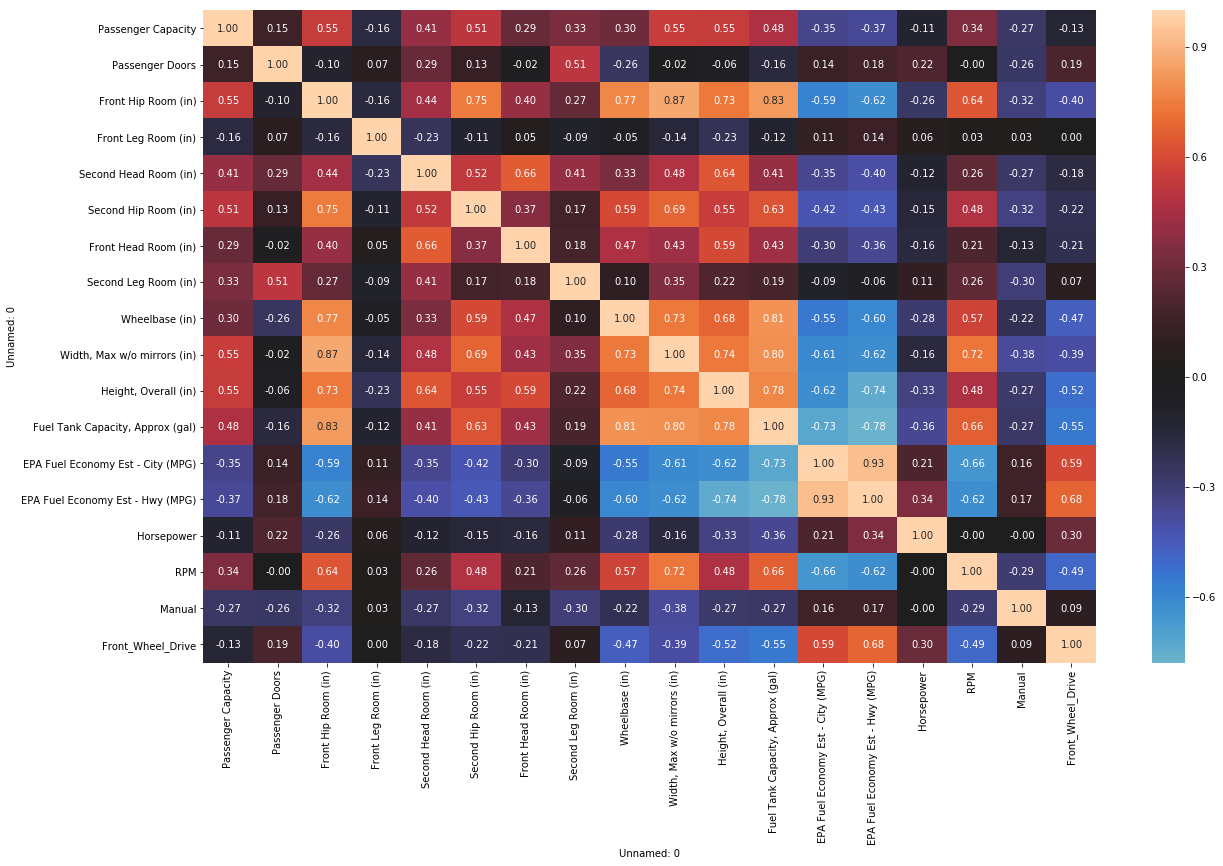

In [35]:
plt.figure(figsize=(20,12))
sns.heatmap(data.iloc[:,1:19].corr(),annot=True,center=0, fmt='0.2f')

In [23]:
data = data.drop(columns=['Front Shoulder Room (in)','Second Shoulder Room (in)'])

After the number of data features has been winnowed, all rows with missing data were dropped, leaving about 18,000 vehicles. This is just over half of the original data set but should still be demonstrative. It is likely that this has increased bias towards specific manufacturers, however, since missing data is probably prevalent across each manufacturer's vehicles.

In [24]:
data.dropna().shape

(17799, 28)

In [25]:
data = data.dropna()

### Research Plan

A combination of GridSearchCV and model-specific cross validation functions from the scikit-learn toolbox was used for the following models:
- K-Nearest Neighbor
- Decision Tree
- Random Forest
- Ordinary Least Squares Regression
- Ridge Regression
- Lasso Regression
- Support Vector Regression
- Linear Support Vector Regression
- Gradient Boosted Regression
- Ada Boosted Regression

Once optimal hyperparameter sets were found, cross validation was performed on the best estimators for each model comparing the training set, test set and full set of data to compare $R^2$ scores across folds.

#### Model Cross Validation Score function
Since model comparisons will be similar, a cross validation score function was written. It performs cross validation using a given model estimator on the training set, the test set and the combined set. A boxplot comparing the $R^{2}$ scores for each fold is also generated.

In [106]:
def model_cv_scores(model_estimator, X_train, Y_train, X_test, Y_test, cv_folds=12, show_graph=True, graph_title=''):
    
    X = X_train.append(X_test)
    Y = Y_train.append(Y_test)
    
    score_train = cross_val_score(model_estimator, X_train, Y_train, cv=12, n_jobs=5)
    score_test = cross_val_score(model_estimator, X_test, Y_test, cv=12, n_jobs=5)
    score_full = cross_val_score(model_estimator, X, Y, cv=12, n_jobs=5)
    
    if show_graph==True:
        plt.figure
        plt.title('{}\nCross Validation (12 folds): R\u00b2'.format(graph_title))
        plt.boxplot([score_train, score_test, score_full],labels=['Training','Test','Full'])
        plt.show()

    if hasattr(model_estimator,'best_params_'):
        print("Best parameters:   {}".format(model_estimator.best_params_))
        
    print("R\u00b2 (training set): {0:0.5f} (+/- {1:0.5f})".format(score_train.mean(), score_train.std() * 2))
    print("R\u00b2 (test set):     {0:0.5f} (+/- {1:0.5f})".format(score_test.mean(), score_test.std() * 2))
    print("R\u00b2 (full set):     {0:0.5f} (+/- {1:0.5f})".format(score_full.mean(), score_full.std() * 2))
    
    return score_train, score_test, score_full

#### Data Preparation

All boolean data were explicitly converted to numeric.

In [27]:
data = data*1

tgt = data#.query('Automatic == False')
#tgt = tgt.loc[:, ~tgt.columns.isin(['Automatic'])]

MSRP was defined as the outcome variable with all of the remaining variables used as predictors.

In [ ]:
Y = tgt['MSRP']
X = tgt.loc[:, ~tgt.columns.isin(['MSRP'])]

The data were split into a 80% training/20% test set.

In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

### K-Nearest Neighbors
GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|n_neighbors|1-5|3
|weights|uniform/distance|distance

Both the training and full sets have relatively high $R^2$ values with a tight range among folds but this falls, with a significantly wider range when comparing the test set.

|Set|Mean|95% CI
|-|-|-
|Training|0.93058|0.04622
|Test|0.81944|0.12264
|Full|0.93559|0.04441

In [74]:
# K Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor(weights='distance')
knn_fit = GridSearchCV(knn,{'weights':['uniform','distance'],'n_neighbors':range(1,5)},cv=5,n_jobs=5).fit(X_train, Y_train)

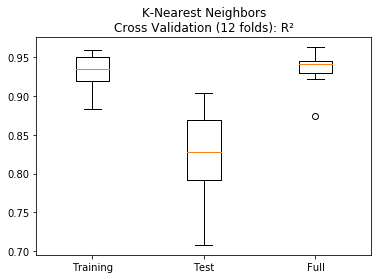

Best parameters:   {'n_neighbors': 3, 'weights': 'distance'}
R² (training set): 0.93058 (+/- 0.04622)
R² (test set):     0.81944 (+/- 0.12264)
R² (full set):     0.93559 (+/- 0.04441)


In [75]:
knn_train, knn_test, knn_full = model_cv_scores(knn_fit, X_train, Y_train, X_test, Y_test, 12, True, 'K-Nearest Neighbors')

### Decision Tree
GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|max_depth|1-8|7
|max_features|1-10|7

The Decision Tree model performs worse than the K-Nearest Neighbors model, although the results of the test set are more consistent to the training set.

|Set|Mean|95% CI
|-|-|-
|Training|0.79843|0.06719
|Test|0.74166|0.19937
|Full|0.81530|0.04257

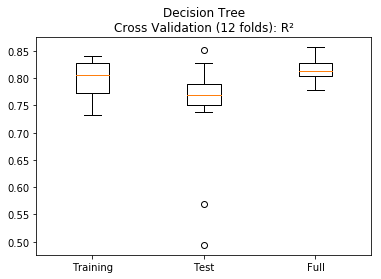

Best parameters:   {'max_depth': 7, 'max_features': 7}
R² (training set): 0.79843 (+/- 0.06719)
R² (test set):     0.74166 (+/- 0.19937)
R² (full set):     0.81530 (+/- 0.04257)


In [210]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
grid_values = {'max_features': range(1,10),'max_depth':range(1,8)}
dt_fit = GridSearchCV(dt, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train, Y_train)

dt_train, dt_test, dt_full = model_cv_scores(dt_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Decision Tree')

### Random Forest
To increase accuracy, n_estimators was increased to 100 and then GridSearchCV was used to determine optimal hyperparameters:

|Parameter|Range/Options|Optimal
|-|-|-
|max_depth|2-5|4
|max_features|3-7|6

The Random Forest model performs worse than either of the two previous models, although it does have the tighest 95% confidence intervals.

|Set|Mean|95% CI
|-|-|-
|Training|0.71925|0.04571
|Test|0.68989|0.09619
|Full|0.72416|0.04512

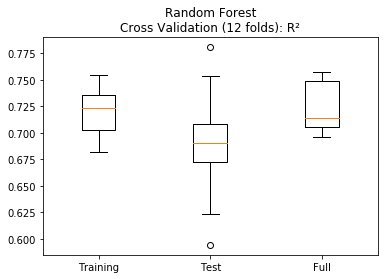

Best parameters:   {'max_depth': 4, 'max_features': 6, 'n_estimators': 100}
R² (training set): 0.71925 (+/- 0.04571)
R² (test set):     0.68989 (+/- 0.09619)
R² (full set):     0.72416 (+/- 0.04512)


In [44]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

grid_values = {'n_estimators': [100], 'max_features': range(3,7),'max_depth':range(2,5)}
rf_fit = GridSearchCV(rf, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train, Y_train)

rf_train, rf_test, rf_full = model_cv_scores(rf_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Random Forest')

In [45]:
feature_importances = pd.DataFrame(rf_fit.best_estimator_.feature_importances_, index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                                   importance
Unnamed: 0                                   
RPM                                  0.349089
Width, Max w/o mirrors (in)          0.134117
Wheelbase (in)                       0.106662
EPA Fuel Economy Est - City (MPG)    0.049698
Fuel Tank Capacity, Approx (gal)     0.048335
Front Hip Room (in)                  0.047784
Front Head Room (in)                 0.041612
Second Leg Room (in)                 0.037324
Front_Wheel_Drive                    0.035865
Height, Overall (in)                 0.032038
Front Leg Room (in)                  0.019695
Second Hip Room (in)                 0.017489
EPA Fuel Economy Est - Hwy (MPG)     0.012964
Truck                                0.012086
Passenger Doors                      0.011662
Manual                               0.010255
Sedan                                0.007631
Passenger Capacity                   0.006247
All_Wheel_Drive                      0.004976
Second Head Room (in)             

### Ordinary Least Squares Regression
The OLS model performs comparably to Random Forest but worse than either of the two previous models.

|Set|Mean|95% CI
|-|-|-
|Training|0.67846|0.03753
|Test|0.66948|0.10856
|Full|0.67608|0.03619

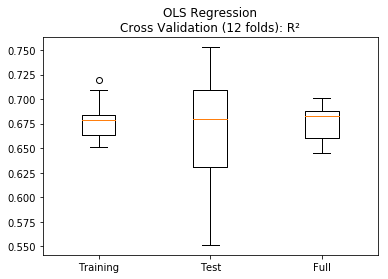

R² (training set): 0.67846 (+/- 0.03753)
R² (test set):     0.66948 (+/- 0.10856)
R² (full set):     0.67608 (+/- 0.03619)


In [118]:
# Ordinary Least Squares Regression
from sklearn.linear_model import LinearRegression
ols_fit = LinearRegression(n_jobs=5).fit(X_train, Y_train)

ols_train, ols_test, ols_full = model_cv_scores(ols_fit, X_train, Y_train, X_test, Y_test, 12, True, 'OLS Regression')

### Ridge Regression
RidgeCV was used to determine optimal alpha:

|Parameter|Range/Options|Optimal
|-|-|-
|alpha|1e-3...1e3|10

The Ridge regression performs similarly to the OLS model.

|Set|Mean|95% CI
|-|-|-
|Training|0.67846|0.03753
|Test|0.66930|0.10859
|Full|0.67608|0.03617

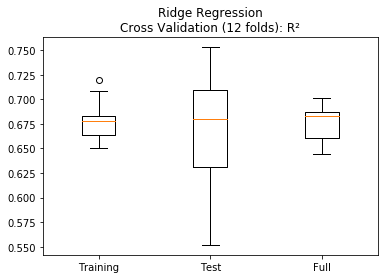

R² (training set): 0.67846 (+/- 0.03753)
R² (test set):     0.66930 (+/- 0.10859)
R² (full set):     0.67608 (+/- 0.03617)
Best alpha: 10.0


In [141]:
# Ridge Regression
from sklearn.linear_model import RidgeCV
ridge_fit = RidgeCV(cv=10,alphas=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]).fit(X_train, Y_train)

ridge_train, ridge_test, ridge_full = model_cv_scores(ridge_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Ridge Regression')
print('Best alpha: {}'.format(ridge_fit.alpha_))

### Lasso Regression
LassoCV was used to determine optimal alpha:

|Parameter|Range/Options|Optimal
|-|-|-
|alpha|eps=1e-4|230

The Ridge regression performs similarly to the OLS and Ridge regression models.

|Set|Mean|95% CI
|-|-|-
|Training|0.67496|0.03709
|Test|0.66739|0.10773
|Full|0.67277|0.03593

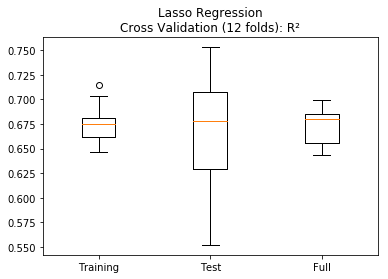

R² (training set): 0.67496 (+/- 0.03709)
R² (test set):     0.66739 (+/- 0.10773)
R² (full set):     0.67277 (+/- 0.03593)
Best alpha: 230.3647672383914


In [139]:
# Lasso Regression
from sklearn.linear_model import LassoCV
lasso_fit = LassoCV(cv=10,eps=1e-4).fit(X, Y)

lasso_train, lasso_test, lasso_full = model_cv_scores(lasso_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Lasso Regression')
print('Best alpha: {}'.format(lasso_fit.alpha_))

Initial observations from the Lasso regression coefficients:
- Consumers do not want to refuel often: both higher fuel tank capacity and in city mileage are important.
- Leg room appears to be the most important 'roominess' factor.
- Head room does not seem important. Although it has a negative coefficient, it is probably partly offset by the leg room coeffiients.
- The negative sign for wheelbase suggests that consumers prefer shorter cars. However, this would seem to suggest less leg room (at least in the rear) so this may also be partially offset by leg room.
- Mathematically, Horsepower = Torque x RPM / 5252. Although RPM and Horsepower have opposite signs, RPM more than offsets the corresponding change in Horsepower.

In [126]:
lasso_coefs = pd.DataFrame(lasso_fit.coef_, index=X.columns,
                                   columns=['Coefficient']).sort_values('Coefficient', ascending=False)
print(lasso_coefs)

                                   Coefficient
Unnamed: 0                                    
Fuel Tank Capacity, Approx (gal)    377.721592
EPA Fuel Economy Est - City (MPG)   345.035623
Second Leg Room (in)                289.621961
Front Leg Room (in)                 243.139156
RPM                                 161.483304
Passenger Capacity                    0.000000
Manual                               -0.000000
Truck                                -0.000000
Station_Wagon                         0.000000
Coupe                                -0.000000
Sedan                                 0.000000
SUV                                   0.000000
Four_Wheel_Drive                      0.000000
All_Wheel_Drive                       0.000000
Rear_Wheel_Drive                     -0.000000
Front_Wheel_Drive                    -0.000000
EPA Fuel Economy Est - Hwy (MPG)      0.000000
Passenger Doors                       0.000000
Height, Overall (in)                  0.000000
Width, Max w/

Looking at correlations:
- Leg room does not actually appear to be correlated with any of the other variables (including front vs. second leg room).
- RPM looks completely uncorrelated to horsepower.
- There is a fairly high negative relationship between fuel tank capacity and city MPG suggesting a target 'miles per tank' so an ideal car would have both.

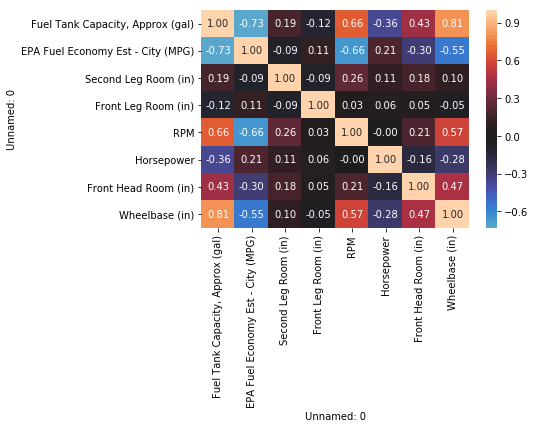

In [149]:
sns.heatmap(X.loc[:,['Fuel Tank Capacity, Approx (gal)','EPA Fuel Economy Est - City (MPG)',\
        'Second Leg Room (in)','Front Leg Room (in)','RPM','Horsepower','Front Head Room (in)','Wheelbase (in)']].corr(),\
        annot=True,center=0, fmt='0.2f')

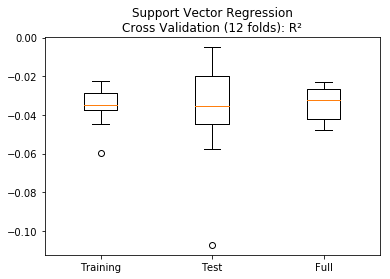

R² (training set): -0.03479 (+/- 0.02000)
R² (test set):     -0.03719 (+/- 0.05240)
R² (full set):     -0.03440 (+/- 0.01807)


In [151]:
# Support Vector Regressor
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf', gamma='scale')
grid_values = {'C': [1], 'epsilon': [0.1]}
svr_fit = GridSearchCV(rf, param_grid = grid_values,cv=5,iid=True,n_jobs=5).fit(X_train,Y_train)

svr_train, svr_test, svr_full = model_cv_scores(svr_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Support Vector Regression')

C:\Users\yfsta\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


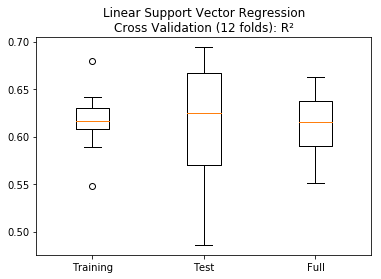

R² (training set): 0.61639 (+/- 0.05970)
R² (test set):     0.60990 (+/- 0.13149)
R² (full set):     0.61073 (+/- 0.07152)


In [153]:
# Linear Support Vector Regressor
from sklearn.svm import LinearSVR
lin_svr_fit = LinearSVR(max_iter=10000).fit(X_train,Y_train)

lin_svr_train, lin_svr_test, lin_svr_full = model_cv_scores(lin_svr_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Linear Support Vector Regression')

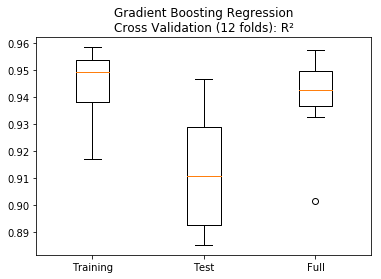

R² (training set): 0.94382 (+/- 0.02558)
R² (test set):     0.91165 (+/- 0.03735)
R² (full set):     0.94093 (+/- 0.02803)


In [155]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500,
          'max_depth': 3}

# Initialize and fit the model.
gb_fit = GradientBoostingRegressor(**params).fit(X_train, Y_train)

gb_train, gb_test, gb_full = model_cv_scores(gb_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Gradient Boosting Regression')

In [ ]:
# AdaBoost Classifier
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(n_estimators=100).fit(X_train,Y_train)

ada_train, ada_test, ada_full = model_cv_scores(ada_fit, X_train, Y_train, X_test, Y_test, 12, True, 'Ada Boosting Regression')

### Principal Component Analysis

In [79]:
X_scaled = preprocessing.scale(X)
pca = PCA(n_components=6).fit(X_scaled)
pca.explained_variance_ratio_

__main__:1: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by the scale function.


array([0.33311485, 0.11606351, 0.07674442, 0.06300084, 0.05656175,
       0.04817505])

In [65]:
pd.DataFrame({'Feature':X_train.columns,
        '1st PC': pca.components_[0,:],
        '2nd PC': pca.components_[1,:],
        '3rd PC': pca.components_[2,:],
        '4th PC': pca.components_[3,:],
        '5th PC': pca.components_[4,:],
        '6th PC': pca.components_[5,:]})

,Feature,1st PC,2nd PC,3rd PC,4th PC,5th PC,6th PC
0,Passenger Capacity,0.184273,-0.241003,0.048434,-0.000645,0.292275,0.147674
1,Passenger Doors,-0.034250,-0.447982,0.032465,-0.131214,-0.256058,-0.061991
2,Front Hip Room (in),0.290811,-0.015368,0.184712,-0.049877,0.064691,-0.040837
3,Front Leg Room (in),-0.059231,0.079705,0.069770,-0.254464,-0.339662,0.066611
4,Second Head Room (in),0.199187,-0.278972,-0.054048,0.219484,-0.093867,0.151815
5,Second Hip Room (in),0.229869,-0.125710,0.250284,-0.053436,0.021291,0.169095
6,Front Head Room (in),0.188396,-0.074256,0.024699,0.264395,-0.188097,0.223234
7,Second Leg Room (in),0.077914,-0.381401,0.083831,-0.083197,-0.028336,-0.181622
8,Wheelbase (in),0.275432,0.159739,0.236117,-0.009209,-0.133777,0.017515
9,"Width, Max w/o mirrors (in)",0.289819,-0.071858,0.129533,-0.101715,0.083484,-0.093366


In [86]:
X_pca_raw = pca.transform(X_scaled)
X_pca = pd.DataFrame(data=X_pca_raw,index=X.index)
X_pca_train, X_pca_test, Y_pca_train, Y_pca_test = train_test_split(X_pca, Y, test_size=0.2)

### SelectKBest

In [77]:
# Select KBest
X_best = SelectKBest(f_classif, k=10).fit_transform(X, Y)
X_best_train, X_best_test, Y_best_train, Y_best_test = train_test_split(X_best, Y, test_size=0.2)